In [9]:
%matplotlib inline
import sys
from collections import defaultdict, Counter
import networkx as nx
import numpy as np
import pylab as plt
import torch as th
import json
import math
#import matplotlib.cm as cm
import statsmodels.api as sm
from os import listdir
from scipy.stats.stats import pearsonr
import json
import random
import itertools
from copy import deepcopy
import time
import scipy as sp
from scipy.sparse import csr_matrix
import matplotlib.cm as cm
from numpy.random import choice
import itertools
from sklearn import manifold
import operator
import itertools
from datetime import datetime as dt
import matplotlib.mlab as mlab
from scipy.stats import norm
import re
from scipy import stats
from scipy.spatial import Voronoi
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats.mstats import zscore

# flush print
def flushPrint(d):
    sys.stdout.write('\r')
    sys.stdout.write(d)
    sys.stdout.flush()

def DiffusionWeightAverage(threshold,data):#[value,samplesize] in data
    smoothData=[data[0]]
    for n,j in enumerate(data[1:]):
        value,sampleSize=j
        if sampleSize<threshold:
            lastValue,lastSampleSize=smoothData[n-1]
            value=np.average([lastValue,value], weights=[lastSampleSize, sampleSize])
        smoothData.append([value,sampleSize])
    return smoothData

def OLSRegressFit(x,y):
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant, beta = res.params
    r2 = res.rsquared
    return [constant,beta] 

def clean(s): return re.sub('[^A-Za-z0-9]+', ' ', s).strip().lower()

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return phi,rho

# Co-occur data

In [275]:
'''
# open syllabus
E={}
n=0
with open('/Users/lingfeiw/Documents/research/KatyPNAS/openSy/coocur.txt','r') as f:
    for line in f:#163
        n+=1
        if n%100000==0:
            flushPrint(str(n/100000))
        line=line.strip().split('\t')
        if len(line)==3:
            i,j,w=line
            E[(i,j)]=int(w)
E=sorted(E.items(),key=lambda x:-x[1])
path='/Users/lingfeiw/Documents/research/KatyPNAS/data/skill_cooccur/openSy_Co.txt'
with open(path,'w') as f:
    for k,v in sorted(E.items(),key=lambda x:-x[1]):
        i,j=k
        f.write(i+'\t'+j + '\t'+str(v)+'\n')
        
# BG
W={}
E={}
n=0
with open('/Users/lingfeiw/Documents/research/KatyPNAS/data/skill_cooccur/skills_MAIN_maxmatch_2010-2016.nwb','r') as f:
    for line in f:#80
        n+=1
        if n%100000==0:
            flushPrint(str(n/100000))
        line=line.strip().split('\t')
        if len(line)==2:
            idx,skill=line
            W[int(idx)]=skill.split('"')[1]
        if len(line)==3:
            i,j,w=map(int,line)
            E[(i,j)]=w
S={}
for k,v in E.items():
    i,j=k
    S[(W[i],W[j])]=v
path='/Users/lingfeiw/Documents/research/KatyPNAS/data/skill_cooccur/BG_Co.txt'
with open(path,'w') as f:
    for k,v in sorted(S.items(),key=lambda x:-x[1]):
        i,j=k
        f.write(i+'\t'+j + '\t'+str(v)+'\n')
        
# WOS papers
E=defaultdict(lambda:0)
n=0
with open('/Users/lingfeiw/Documents/research/KatyPNAS/shutian/MaxMatchWOS.txt','r') as f:
    for line in f:#158
        n+=1
        if n%100000==0:
            flushPrint(str(n/100000))
        line=line.strip().split('\t')
        vs=sorted(line[1:])
        for i,j in itertools.combinations(vs, 2):
            E[(i,j)]+=1
path='/Users/lingfeiw/Documents/research/KatyPNAS/data/skill_cooccur/WOS_Co.txt'
with open(path,'w') as f:
    for k,v in sorted(E.items(),key=lambda x:-x[1]):
        i,j=k
        f.write(i+'\t'+j + '\t'+str(v)+'\n')

# aggregate data
with open('/Users/lingfeiw/Documents/bigdata/openSy/IdAbstract.txt','w') as f:
    for nid in range(1000):
        nid=str(nid).zfill(5)
        address='/Users/lingfeiw/Documents/bigdata/openSyReal/part-'+nid.zfill(5)+'-acad4d4e-3b83-4f3a-a99c-a3e6e7394308-c000.json'
        flushPrint(nid)
        #for line in open('/Users/lingfeiw/Documents/research/KatyPNAS/openSy/test.json', 'r'):
        for line in open(address,'r'):
            line=json.loads(line)
            idd=line['id']
            if 'source_anchor' in line and 'year' in line:
                title=line['source_anchor'].lower()
                title=title.replace('\t',' ')
                title=title.replace('\n',' ')
                title=title.replace('\r',' ')
                title=title.encode('utf-8','ignore')
                text=line['text'].lower()
                text=text.replace('\t',' ')
                text=text.replace('\n',' ')
                text=text.replace('\r',' ')
                text=text.encode('utf-8','ignore')
                year=line['year']
                #year=int(year)
                #if 2010<=year<=2016:
                f.write(str(year)+'\t'+str(idd)+'\t'+title+'\t'+text +'\n')
# clean data
L=defaultdict(int)
n=0
with open('/Users/lingfeiw/Documents/bigdata/openSy/IdAbstract_2010_2016_clean.txt','w') as wf:
    with open('/Users/lingfeiw/Documents/bigdata/openSy/IdAbstract.txt','r') as f:
        for line in f:
            n+=1
            if n%10000==0:
                flushPrint(str(n/10000))
            year, idd,title,text=line.strip().split('\t')
            if 2010<=int(year)<=2016:
                #title=filter(lambda x: x in printable, title)
                #text=filter(lambda x: x in printable, text)
                text=text.replace('\t',' ').replace('\n',' ').replace('\r',' ')
                text=[s for s in text.split(' ') if len(s)<=35]
                #
                l=len(text)
                L[l]+=1
                if l>1000:
                    text=text[:1000]
                text=' '.join(text)
                wf.write(year+'\t'+str(idd)+'\t'+title+'\t'+text +'\n')

# calcualte yearly frequency
nf=defaultdict(lambda:0)
for nid in range(1000):
    nid=str(nid).zfill(5)
    address='/Users/lingfeiw/Documents/bigdata/openSyReal/part-'+nid.zfill(5)+'-acad4d4e-3b83-4f3a-a99c-a3e6e7394308-c000.json'
    flushPrint(nid)
    #for line in open('/Users/lingfeiw/Documents/research/KatyPNAS/openSy/test.json', 'r'):
    for line in open(address,'r'):
        try:
            line=json.loads(line)
            year=line['year']
            nf[year]+=1
        except:
            pass
        
# Open syllabus

skills={}
with open('/Users/lingfeiw/Documents/research/KatyPNAS/shutian/skills-list-MAIN-2010-2016.txt','r') as f:
    for line in f:
        line=line.strip().split('\t')
        skills[line[0].lower()]=0

E=defaultdict(lambda:0)
n=0
with open('/Users/lingfeiw/Documents/research/KatyPNAS/data/skill_cooccur/OpenSyIdAbstract2010-2016-out.txt','r') as f:
    for line in f:#27
        n+=1
        if n%100000==0:
            flushPrint(str(n/100000))
        line=line.strip().split('\t')
        vs=sorted([i for i in line if i in skills])
        if len(vs)>=2:
            for i,j in itertools.combinations(vs, 2):
                E[(i,j)]+=1

path='/Users/lingfeiw/Documents/research/KatyPNAS/data/skill_cooccur/OpenSy_Co.txt'
with open(path,'w') as f:
    for k,v in sorted(E.items(),key=lambda x:-x[1]):
        i,j=k
        if i and j:
            f.write(i+'\t'+j + '\t'+str(v)+'\n')

'''

163

In [2]:
SE=set()
with open('/Users/lingfeiw/Documents/research/KatyPNAS/BG/skills-list-DSDE-2010-2016.txt','rb') as f:
    for line in f:
        line=line.strip().split('\r')
        SE.add(line[0].lower())
len(SE)

2968

In [7]:
# percentage of DSDE course
n=0
m=0
with open('/Users/lingfeiw/Documents/research/KatyPNAS/data/skill_cooccur/OpenSyIdAbstract2010-2016-out.txt','r') as f:
    for line in f:#27
        n+=1
        if n%100000==0:
            flushPrint(str(n/100000))
        line=line.strip().split('\t')
        if set(line).intersection(SE):
            m+=1

27

In [8]:
m,m

(2731863, 2731863)

## 1. Core co-occur data

In [4]:
a,b,c=[2*6199739000.0,2*112377820.0,2*69275242.0]

In [7]:
B={}
n=0
with open('/Users/lingfeiw/Documents/research/KatyPNAS/data/skill_cooccur/BG_Co.txt','r') as f:
    for line in f:#80
        n+=1
        if n%100000==0:
            flushPrint(str(n/100000))
        i,j,w=line.strip().split('\t')
        i,j=sorted([i,j])
        B[(i,j)]=int(w)/a
O={}
n=0
with open('/Users/lingfeiw/Documents/research/KatyPNAS/data/skill_cooccur/openSy_Co.txt','r') as f:
    for line in f:#17
        n+=1
        if n%100000==0:
            flushPrint(str(n/100000))
        i,j,w=line.strip().split('\t')
        i,j=sorted([i,j])
        O[(i,j)]=int(w)/b
W={}
n=0
with open('/Users/lingfeiw/Documents/research/KatyPNAS/data/skill_cooccur/WOS_Co.txt','r') as f:
    for line in f:#163
        n+=1
        if n%100000==0:
            flushPrint(str(n/100000))
        i,j,w=line.strip().split('\t')
        i,j=sorted([i,j])
        W[(i,j)]=int(w)/c
# import skills
skills={}
with open('/Users/lingfeiw/Documents/research/KatyPNAS/shutian/skills-list-MAIN-2010-2016.txt','r') as f:
    for line in f:
        line=line.strip().split('\t')
        skills[line[0].lower()]=0
len(skills)

17

13242

In [11]:
len(B),len(W),len(O),len(skills)

(8080559, 1715255, 1750532, 13242)

## 1.1  probability of single skills in three datasets

In [12]:
#
fb=defaultdict(int)
for k,w in B.items():
    i,j=k
    fb[i]+=w
    fb[j]+=w
fw=defaultdict(int)
for k,w in W.items():
    i,j=k
    fw[i]+=w
    fw[j]+=w
fo=defaultdict(int)
for k,w in O.items():
    i,j=k
    fo[i]+=w
    fo[j]+=w
b,w,o=np.array([[fb[i],fw[i],fo[i]] for i in skills if fb[i]*fw[i]*fo[i]>0]).T
lb,lo,lw=[np.log(b),np.log(o),np.log(w)]

In [17]:
pearsonr(lb,lo),pearsonr(lw,lo),pearsonr(lb,lw),len(b)

((0.64377338709745113, 0.0),
 (0.43214183126932632, 3.8312202919135753e-316),
 (0.080490278980824989, 1.5818509287704315e-11),
 6992)

## 1.2 Pairwise combination of skills

In [23]:
u = set.intersection(set(B.keys()),set(W.keys()),set(O.keys()))

In [25]:
U={}
for i in u:
    U[i]=[B[i],W[i],O[i]]

In [27]:
len(U)

381879

In [30]:
b1,w1,o1=np.array(U.values()).T
lb1,lo1,lw1=[np.log(b1),np.log(o1),np.log(w1)]

In [51]:
pearsonr(lb1,lo1),pearsonr(lw1,lo1),pearsonr(lb1,lw1),len(b1)

((0.53780738345087853, 0.0),
 (0.19253551157879725, 0.0),
 (-0.053266403554345955, 5.8877959603931924e-238),
 381879)

In [33]:
def densitydataPlot(dx,dy,xmin, xmax,ymin, ymax,dataArray):
    a,b=dataArray.T
    Y, X = np.mgrid[slice(xmin, xmax + dy, dy),
                    slice(ymin, ymax + dx, dx)]
    def Zdensityfunction(X,Y,dx,dy):
        nX=X.reshape([X.shape[0]*X.shape[1],1])
        nY=Y.reshape([Y.shape[0]*Y.shape[1],1])
        nXY=np.concatenate((nX,nY), axis=1)
        nZ=[]
        for i in nXY:
            x,y = i
            z = len([j for j in dataArray if j[0]>x-dx and j[0]<x+dx and j[1]>y-dy and j[1]<y+dy])
            nZ.append(z)
        return np.array(nZ).reshape(X.shape)
    Z=Zdensityfunction(X,Y,dx,dy)    
    plt.contourf(X + dx , Y + dy , Z,cmap ="RdBu_r",origin='lower')
    #plt.xlim(-20,0)
    plt.colorbar()

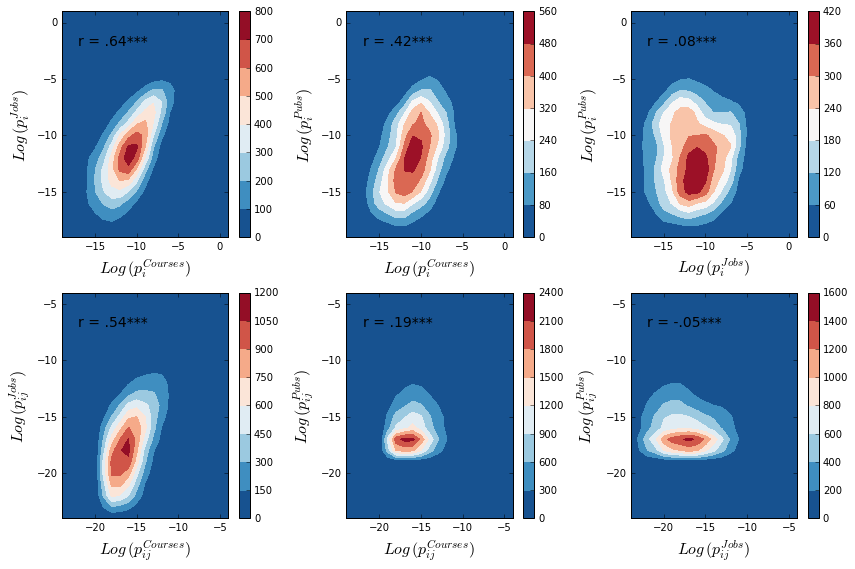

In [241]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(231)
dd=1
densitydataPlot(dd,dd,-20,0,-20,0,np.array(zip(lo,lb)))
plt.xlabel(r'$Log\,(p_{i}^{Courses})$',size=16)
plt.ylabel(r'$Log\,(p_{i}^{Jobs})$',size=16)
plt.text(-17,-2,'r = .64***',size=14)
#
ax = fig.add_subplot(232)
densitydataPlot(dd,dd,-20,0,-20,0,np.array(zip(lo,lw)))
plt.xlabel(r'$Log\,(p_{i}^{Courses})$',size=16)
plt.ylabel(r'$Log\,(p_{i}^{Pubs})$',size=16)
plt.text(-17,-2,'r = .42***',size=14)
#
ax = fig.add_subplot(233)
densitydataPlot(dd,dd,-20,0,-20,0,np.array(zip(lb,lw)))
plt.xlabel(r'$Log\,(p_{i}^{Jobs})$',size=16)
plt.ylabel(r'$Log\,(p_{i}^{Pubs})$',size=16)
plt.text(-17,-2,'r = .08***',size=14)
#
ax = fig.add_subplot(234)
densitydataPlot(dd,dd,-25,-5,-25,-5,np.array(random.sample(zip(lo1,lb1),10000)))
plt.xlabel(r'$Log\,(p_{ij}^{Courses})$',size=16)
plt.ylabel(r'$Log\,(p_{ij}^{Jobs})$',size=16)
plt.text(-22,-7,'r = .54***',size=14)
#
ax = fig.add_subplot(235)
densitydataPlot(dd,dd,-25,-5,-25,-5,np.array(random.sample(zip(lo1,lw1),10000)))
plt.xlabel(r'$Log\,(p_{ij}^{Courses})$',size=16)
plt.ylabel(r'$Log\,(p_{ij}^{Pubs})$',size=16)
plt.text(-22,-7,'r = .19***',size=14)
#
ax = fig.add_subplot(236)
densitydataPlot(dd,dd,-25,-5,-25,-5,np.array(random.sample(zip(lb1,lw1),10000)))
plt.xlabel(r'$Log\,(p_{ij}^{Jobs})$',size=16)
plt.ylabel(r'$Log\,(p_{ij}^{Pubs})$',size=16)
plt.text(-22,-7,'r = -.05***',size=14)
#
plt.tight_layout()
plt.savefig('/Users/lingfeiw/Documents/research/KatyPNAS/data/skill_cooccur/pearson.pdf')

## 1.3 Pairwise combinations for embedding

In [161]:
# top 1000 skills
ts=sorted([(fb[i]+fo[i]+fw[i],i) for i in skills if fb[i]*fw[i]*fo[i]>0],reverse=True)
len(ts)

6992

In [162]:
top1000=zip(*ts[:1000])[1]
top1000s=set(top1000)
path='/Users/lingfeiw/Documents/research/KatyPNAS/data/skill_cooccur/BGskillsTop1000.txt'
#with open(path,'w') as f:
#    for i in top1000:
#        vs=[i,fb[i],fo[i],fw[i]]
#        f.write('\t'.join(map(str,vs))+'\n')

In [156]:
'''
def exportSkeleton(B,top1000s,path):
    F=defaultdict(lambda:[])
    for k,w in B.items():
        i,j=k
        if i in top1000s and j in top1000s:
            F[i].append([w,j])
            F[j].append([w,i])
    E={}
    for s in top1000s:
        for w,j in sorted(F[s],reverse=True)[:10]:
            E[(s,j)]=w
    with open(path,'w') as f:
        for k,v in sorted(E.items(),key=lambda x:-x[1]):
            i,j=k
            v=int(v/min(E.values()))
            f.write(i+'\t'+j + '\t'+str(v)+'\n')
        
path='/Users/lingfeiw/Documents/research/KatyPNAS/data/skill_cooccur/OpenSy_CoTop10000.tsv'
exportSkeleton(O,top1000s,path)
'''

In [129]:
with open("/Users/lingfeiw/Documents/research/KatyPNAS/data/skill_cooccur/OpenSy.tsv", 'rb') as f:
    for line in f:
        i,j,w=line.strip().split('\t')
        gS.add_edge(i,j,weight=int(w))

# Embedding 

In [10]:
def getData(path,fb):
    pt = th.load(path)
    pos=dict(zip(pt['objects'],pt['model']['lt.weight'].numpy()))
    posP=dict((i,cart2pol(*pos[i])) for i in pos)
    ks=np.array([fb[s] for s in posP])*10000+3
    return posP,ks

In [11]:
top1000=[]
fb={}
fo={}
fw={}
with open('/Users/lingfeiw/Documents/research/KatyPNAS/data/skill_cooccur/BGskillsTop1000.txt', 'rb') as f:
    for line in f:
        s,b,o,w=line.strip().split('\t')
        top1000.append(s)
        fb[s]=float(b)
        fo[s]=float(o)
        fw[s]=float(w)

In [12]:
Eb={}
with open("/Users/lingfeiw/Documents/research/KatyPNAS/data/skill_cooccur/BG_CoTop10000.tsv", 'rb') as f:
    for line in f:
        i,j,w=line.strip().split('\t')
        Eb[(i,j)]=int(w)/(2*6199739000.0)
Eo={}
with open("/Users/lingfeiw/Documents/research/KatyPNAS/data/skill_cooccur/OpenSy_CoTop10000.tsv", 'rb') as f:
    for line in f:
        i,j,w=line.strip().split('\t')
        Eo[(i,j)]=int(w)/(2*112377820.0)
Ew={}
with open("/Users/lingfeiw/Documents/research/KatyPNAS/data/skill_cooccur/WOS_CoTop10000.tsv", 'rb') as f:
    for line in f:
        i,j,w=line.strip().split('\t')
        Ew[(i,j)]=int(w)/(2*69275242.0)

In [13]:
pathb="/Users/lingfeiw/Documents/research/KatyPNAS/data/skill_cooccur/BG_CoTop10000.pt"
posPb,ksb=getData(pathb,fb)
patho="/Users/lingfeiw/Documents/research/KatyPNAS/data/skill_cooccur/OpenSy_CoTop10000.pt"
posPo,kso=getData(patho,fo)
pathw="/Users/lingfeiw/Documents/research/KatyPNAS/data/skill_cooccur/WOS_CoTop10000.pt"
posPw,ksw=getData(pathw,fw)

In [22]:
for i in Eb:
    if 'communication skills' in i:
        w=np.round(Eb[i],3)
        if w>0:
            print i,Eb[i]

('customer service', 'communication skills') 0.000736165828916
('management', 'communication skills') 0.000951924750381
('communication skills', 'sales') 0.000708069000969
('communication skills', 'management') 0.000951924750381
('sales', 'communication skills') 0.000708069000969
('communication skills', 'customer service') 0.000736165828916


In [234]:
zip(*sorted(fb.items(),key=lambda x:-x[1])[:10])[0]

('management',
 'communication skills',
 'sales',
 'customer service',
 'leadership',
 'marketing',
 'research',
 'planning',
 'finance',
 'problem solving')

In [235]:
topB=['management',
 'communication skills',
 'sales',
 'customer service',
 'leadership',
 'marketing',
 'research',
 'planning',
 'finance',
 'problem solving']
software=['javascript','sql','java','linux','microsoft excel','perl','sas','matlab',
         'mysql','spss']

In [254]:
topb=zip(*sorted(fb.items(),key=lambda x:-x[1])[:20])[0]
topo=zip(*sorted(fo.items(),key=lambda x:-x[1])[:20])[0]
topw=zip(*sorted(fw.items(),key=lambda x:-x[1])[:20])[0]

In [2]:


fig = plt.figure(figsize=(15, 5))
#cmap = cm.get_cmap('rainbow_r',10)
ax = fig.add_subplot(131, projection='polar')
embeddingP = np.array([posPb.values()]).T
ax.scatter(embeddingP[0], embeddingP[1],c='SteelBlue',
           s=ksb,linewidth=0,alpha=0.7,zorder=2)
for i in topB:
    phi,rho=posPb[i]
    plt.text(phi,rho,i,ha='center',color='Orange',size=8)
for i in software:
    phi,rho=posPb[i]
    plt.text(phi,rho,i,ha='center',size=8)
for i in topb:
    if i not in topB and i not in software:
        phi,rho=posPb[i]
        plt.text(phi,rho,i,ha='center',color='SteelBlue',size=8)
for k,v in Eb.items():
    i,j=k
    if v>0.00001:
        xi,yi=posPb[i]
        xj,yj=posPb[j]
        plt.plot([xi,xj],[yi,yj],color='gray',alpha=v*1000,linewidth=v*10000,zorder=1)
ax.set_rmax(1)
ax.set_yticklabels('')
ax.yaxis.grid(True,color='gray',alpha=0.5,linestyle='-')
ax.spines['polar'].set_visible(False)
ax.xaxis.grid(True,color='gray',alpha=0.5,linestyle='-')
plt.title('Jobs',size=14,y=1.1)
#
ax = fig.add_subplot(132, projection='polar')
embeddingP = np.array([posPo.values()]).T
ax.scatter(embeddingP[0], embeddingP[1],c='r',
           s=kso,linewidth=0,alpha=0.5,zorder=2)
for i in topB:
    phi,rho=posPo[i]
    plt.text(phi,rho,i,ha='center',color='Orange',size=8)
for i in software:
    phi,rho=posPo[i]
    plt.text(phi,rho,i,ha='center',size=8)
for i in topo:
    if i not in topB and i not in software:
        phi,rho=posPo[i]
        plt.text(phi,rho,i,ha='center',color='r',size=8)
for k,v in Eo.items():
    i,j=k
    if v>0.00001:
        xi,yi=posPo[i]
        xj,yj=posPo[j]
        plt.plot([xi,xj],[yi,yj],color='gray',alpha=v*1000,linewidth=v*10000,zorder=1)
ax.set_rmax(1)
ax.set_yticklabels('')
ax.yaxis.grid(True,color='gray',alpha=0.5,linestyle='-')
ax.spines['polar'].set_visible(False)
ax.xaxis.grid(True,color='gray',alpha=0.5,linestyle='-')
plt.title('Courses',size=14,y=1.1)
#
ax = fig.add_subplot(133, projection='polar')
embeddingP = np.array([posPw.values()]).T
ax.scatter(embeddingP[0], embeddingP[1],c='#458B74',
           s=ksw,linewidth=0,alpha=0.7,zorder=2)
for i in topB:
    phi,rho=posPw[i]
    plt.text(phi,rho,i,ha='center',color='Orange',size=8)
for i in software:
    phi,rho=posPw[i]
    plt.text(phi,rho,i,ha='center',size=8)
for i in topw:
    if i not in topB and i not in software:
        phi,rho=posPw[i]
        plt.text(phi,rho,i,ha='center',color='#458B74',size=8)
for k,v in Ew.items():
    i,j=k
    if v>0.00001:
        xi,yi=posPw[i]
        xj,yj=posPw[j]
        plt.plot([xi,xj],[yi,yj],color='gray',alpha=v*1000,linewidth=v*10000,zorder=1)
ax.set_rmax(1)
ax.set_yticklabels('')
ax.yaxis.grid(True,color='gray',alpha=0.5,linestyle='-')
ax.spines['polar'].set_visible(False)
ax.xaxis.grid(True,color='gray',alpha=0.5,linestyle='-')
plt.title('Publications',size=14,y=1.1)
#
plt.tight_layout()
plt.subplots_adjust(top=0.8)
#plt.savefig('/Users/lingfeiw/Documents/research/KatyPNAS/data/skill_cooccur/hyper.pdf')

NameError: name 'np' is not defined